In [1]:
import os
import pandas as pd
from policies.mappo import MAPPO
from environment.optimization_environment import OptimizationEnv
from environment.utils import parse_config
from datetime import datetime
import numpy as np
import seaborn as sns
import os
import neptune
from neptune.types import File
import argparse 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
from other_algorithms.pso import ParticleSwarmOptimizer
import time
from dotenv import load_dotenv
load_dotenv()

c:\Users\eikpon1\envs\RLEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


True

In [2]:
def initialize(config_path, mode="train", **kwargs):
    env = OptimizationEnv(config_path)
    agent_policy = MAPPO(config_path)
    if mode == "test" or mode == "benchmark":
        model_path = kwargs.get("model_path", None)
        if model_path is None:
            raise ValueError("Model path must be provided for testing")
        agent_policy.load(model_path)
    return env, agent_policy

def print_items(**kwargs):
    for key, value in kwargs.items():
        print(key, value)
        
def get_action(observation_info, agent_policy, env):
    observation, observation_std = observation_info
    actions = np.zeros((env.n_agents, env.n_dim))
    for dim in range(env.n_dim):
        observation[dim] = observation[dim].astype(np.float32)
        #print(observation[dim])
        observation_std[dim] = observation_std[dim].astype(np.float32)
        action = agent_policy.select_action(observation[dim], observation_std[dim])
        actions[:, dim] = action
    return actions

In [3]:
config_path = 'config/config.json'
model_path = "models/gbest_exploiters.pth"
mode = "train"
env, agent_policy = initialize(config_path, mode=mode, model_path=model_path)
config = parse_config(config_path)
agent_policy.set_action_std(config["test_action_std"])

def display_gmm_details(gmm):
    print("Means: ", gmm.means_)
    print("Covariances: ", gmm.covariances_)
    print("Weights: ", gmm.weights_)


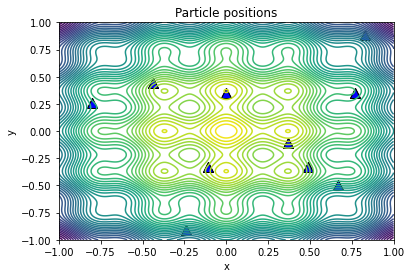

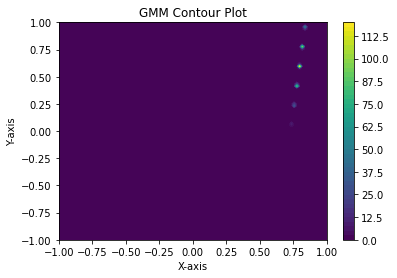

Means:  [[-0.00747558 -0.14122781]
 [ 0.80000021  0.61500293]]
Covariances:  [[[ 0.21610777 -0.08657725]
  [-0.08657725  0.1915149 ]]

 [[ 0.00090152  0.00795448]
  [ 0.00795448  0.07026434]]]
Weights:  [0.80002424 0.19997576]


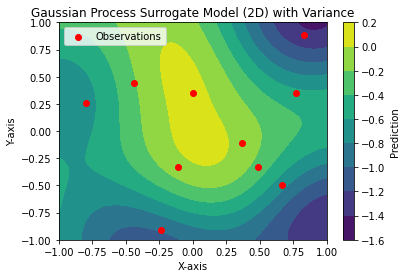

In [4]:
observation_info = env.reset()
env.render()
env.render(type="gmm")
env.render(type="surrogate")
display_gmm_details(env.gmm.gmm)

In [5]:
print(env.surrogate_error)

(3.378668425753565, 1.8381154549574859)


action_mean: tensor([[-0.1244],
        [-0.1749],
        [-0.0522],
        [-0.2210],
        [-0.0576],
        [-0.2270],
        [-0.0836],
        [-0.0286],
        [-0.0827],
        [-0.1732]], device='cuda:0', grad_fn=<AddmmBackward0>)  - state: tensor([[ 0.0000,  0.2618,  0.2000,  0.1922,  0.2618],
        [ 0.0000,  0.2168, -0.5000,  0.4820,  0.2168],
        [ 0.0000,  1.0000,  0.6100,  0.0000,  1.0000],
        [ 0.0000,  0.0994, -1.1900,  0.6965,  0.0994],
        [ 0.0000,  0.6965,  0.6000,  0.2618,  0.6965],
        [ 0.0000,  0.1922, -1.4400,  0.7796,  0.1922],
        [ 0.0000,  0.1510,  0.8200,  0.0994,  0.1510],
        [ 0.0000,  0.7796,  1.0100,  0.1510,  0.7796],
        [ 0.0000,  0.4820,  0.5000,  0.2168,  0.4820],
        [ 0.0000,  0.0000, -0.6100,  1.0000,  0.0000]], device='cuda:0')
action_mean: tensor([[-0.1459],
        [-0.2484],
        [-0.0849],
        [-0.1753],
        [-0.1676],
        [-0.0476],
        [-0.0291],
        [-0.2127],
        [-

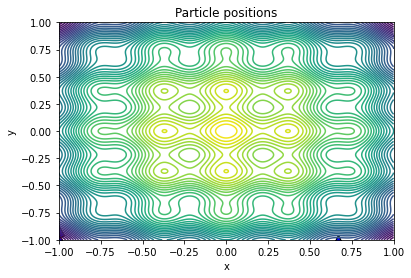

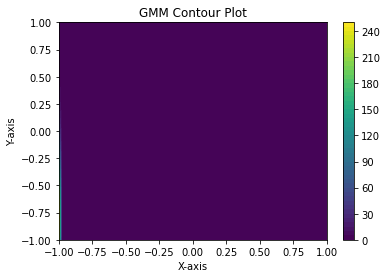

Means:  [[-1.         -0.80256548]
 [ 0.11787244 -0.42805921]]
Covariances:  [[[ 1.00000000e-06  3.05210340e-27]
  [ 3.05210340e-27  2.17438339e-01]]

 [[ 4.43150419e-01 -1.92737286e-01]
  [-1.92737286e-01  5.14735974e-01]]]
Weights:  [0.72646467 0.27353533]


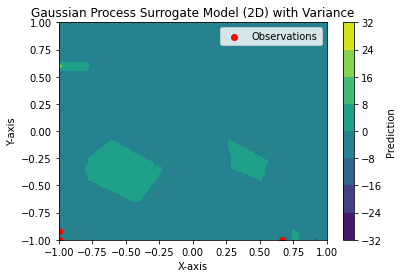

In [7]:
iters  = 25
obs = env.reset()
for i in range(iters):
    actions = get_action(obs, agent_policy, env)
    obs, reward, done, info = env.step(actions)
    if i % 5 == 0:
        #print(f"Observation: {obs[0]}")
        print(f"SURROGATE ERROR: {env.surrogate_error}")    
env.render()
env.render(type="gmm")
env.render(type="surrogate")
display_gmm_details(env.gmm.gmm)


In [ ]:
env.render(type="history", file_path="history.gif")

In [ ]:
env.render()
env.render(type="gmm")
env.render(type="surrogate")
display_gmm_details(env.gmm.gmm)

In [ ]:
prediction = env.surrogate.evaluate(np.array([[-0.0, 0.0]]))
print(prediction)
actual = env.objective_function.evaluate(np.array([[-0.0, 0.0]]))
print(actual)